# Transfer learning with AlexNet
## import 하는 패키지와 라이브러리들

In [11]:
from IPython.core.interactiveshell import InteractiveShell # 표를 이쁘게 만들어주는 기능
import seaborn as sns # 데이터 분포를 시각화해주는 라이브러리

# PyTorch
# torchvision : 영상 분야를 위한 패키지, ImageNet, CIFAR10, MNIST와 같은 데이터셋을 위한 데이터 로더와 데이터 변환기 등이 포함되어 있다.
from torchvision import transforms, datasets, models
import torch

# optim : 가중치를 갱신할 Optimizer가 정의된 패키지. SGD + momentum, RMSProp, Adam등과 같은 알고리즘이 정의되어 있다.
# cuda : CUDA 텐서 유형에 대한 지원을 추가하는 패키지이다. CPU텐서와 동일한 기능을 구현하지만 GPU를 사용하여 계산한다.
from torch import optim, cuda

# DataLoader : 학습 데이터를 읽어오는 용도로 사용되는 패키지.
# sampler : 데이터 세트에서 샘플을 추출하는 용도로 사용하는 패키지
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd # Pandas : Data science를 위한 패키지이다.
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt # matplotlib를 쓸때 seaborn이 있는것과 없는것이 생긴게 다르다.
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

## 초기화
- 학습할 모델 명
- 몇 epoch 학습할 것인지
- 배치 크기는 몇으로 할 것인지

### alexnet, vgg11, vgg16, vgg19, resnet50


In [12]:
# 학습할 모델 입력
model_choice = 'resnet50'

# 몇 epoch 학습할 것인지
training_epoch = 20

# 배치 사이즈 조절
batch_size = 128 

# [ Data Setup ]

## 데이터셋 경로 / GPU 학습 가능 여부 확인

- 불러올 데이터셋의 경로를 지정한다.
- train, validation, test 로 나눠져 있으므로, 각각의 경로를 지정한다.
- 학습된 모델을 저장할 이름을 지정한다.
- 배치크기를 지정한다.
- GPU에서 학습이 가능한지 확인한다.

In [13]:
# Location of data
datadir = '/home/kunde/DeepLearningProject/ingredient_data_TR7_VA2_TE1/' # 데이터셋 경로
traindir = datadir + 'train/'
validdir = datadir + 'valid/'
testdir = datadir + 'test/'

# 학습된 데이터 저장시 이름을 정하는 부분
save_file_name = './ModelSave/' + model_choice + '-transfer.pt'
checkpoint_path = './ModelSave/' + model_choice + '-transfer.pth'

# Whether to train on a gpu
train_on_gpu = cuda.is_available() # GPU를 사용할 수 있는지 없는지 판단한다.
if train_on_gpu == True:
    print('GPU에서 학습이 가능합니다\n')
else:
    print('GPU에서 학습이 불가능합니다.\n')


GPU에서 학습이 가능합니다



## DataFrame 설정 - 데이터셋의 구성을 보기 위한 부분이다

In [14]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# os.listdir(path) : path에 존재하는 파일, 서브폴더 목록을 가져온다.

# Iterate through each category
for d in os.listdir(traindir): # train 데이터의 경로를 탐색한다. os.listdir을 사용하면 train 폴더 내의 폴더들을 순차적으로 탐색한다.
    categories.append(d) # categories라는 리스트에 추가해준다. 폴더명을 카테고리 이름으로 해놨으므로 카테고리명이 저장된다.

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i) # 이미지 열기
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
# Pandas 라이브러리를 이용한 부분. Dataframe은 테이블 형식의 데이터를 다룰때 사용한다. 컬럼, 로우(데이터), 인덱스로 이루어져있다.
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 
                       'n_test': n_test}).sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()
cat_df.tail()

,category,n_train,n_valid,n_test
11,013.garlic,364,104,53
1,014.greenonion,308,88,44
3,021.paprika,298,85,43
9,006.chili,249,71,36
24,002.apple,242,69,34


,category,n_train,n_valid,n_test
16,022.perillaleaf,82,23,11
7,010.daikon,81,23,11
6,018.laver,59,17,8
15,005.chicken,58,17,8
0,012.eggplant,46,12,6


## DataSet 구성하기 - Data Augmentation, ImageFolder, DataLoader

In [15]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

# iter() : 전달된 데이터의 반복자를 꺼내 반환한다.
trainiter = iter(dataloaders['train'])

# next() : 반복자를 입력받아 그 반복자가 다음에 출력해야할 요소를 반환한다.
features, labels = next(trainiter) # 1개만 꺼내기위해 넣은 코드인듯
features.shape, labels.shape # 그냥 단순히 어떤 데이터가 어떤 형태로 들어있는지 알려주기 위한 코드인듯.

n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

There are 30 different classes.


30

# [ CNN Model ]
## 모델 구조 확인 ( 모델 변경할때마다 실행할 것 )

In [16]:
# 구조만 확인하는 부분이다. 그 이유는 모델마다 구조가 다르고, 바꿔줘야 하는 부분이 다르기 때문에 미리 확인하는거다
# 이부분은 실행안하고 건너뛰어도 됨

if model_choice == 'alexnet':
    model = models.alexnet(pretrained=True)
elif model_choice == 'vgg11':
    model = models.vgg11(pretrained=True)
elif model_choice == 'resnet50':
    model = models.resnet50(pretrained=True)
        
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Pretrained Model 불러오는 함수

In [17]:
def get_pretrained_model(model_name):
    # 이 함수는 여러 모델을 선택적으로 불러올 수 있도록 작성되어 있지만
    # 모델마다 파일을 하나씩 만들것이기 때문에 불필요한가? 그렇게 하지말까? 어쩌지..
    # 생각해보니 여러 모델을 만드는것도 일인듯..
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """
    if model_name == 'alexnet': # 알렉스넷인 경우
        model = models.alexnet(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
            
            # 모델 구조를 보면 알겠지만 classifier 부분은 6개의 레이어로 이루어져있다.
            # 여기에서 6번째 레이어의 in_features를 꺼내서 n_inputs에 담는 코드이다.
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        # 모델의 classifier 부분의 6번째 레이어에 새로운 레이어를 넣는 부분이다.
        # Linear 레이어와 Softmax 레이어가 들어간다.
        # Linear 레이어는 Fully-Connected Layer와 동일한 역할을 한다.
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        # ResNet 50의 경우 분류기 부분이 (fc): Linear(in_features=2048, out_features=1000, bias=True) 형식으로 되어있다.
        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    return model

## Pretrained_model 호출, 호출된 모델 Summary 보기

In [18]:
model = get_pretrained_model(model_choice)
summary(model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
              ReLU-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]           4,096
       BatchNorm2d-6          [128, 64, 56, 56]             128
              ReLU-7          [128, 64, 56, 56]               0
            Conv2d-8          [128, 64, 56, 56]          36,864
       BatchNorm2d-9          [128, 64, 56, 56]             128
             ReLU-10          [128, 64, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]          16,384
      BatchNorm2d-12         [128, 256, 56, 56]             512
           Conv2d-13         [128, 256, 56, 56]          16,384
      BatchNorm2d-14         [128, 256,

In [21]:
if model_choice == 'alexnet':
    print(model.classifier[6])
elif model_choice == 'resnet50':
    print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=30, bias=True)
  (1): LogSoftmax()
)


In [22]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:30]

[(0, '001.anchovy'),
 (1, '002.apple'),
 (2, '003.beef'),
 (3, '004.carrot'),
 (4, '005.chicken'),
 (5, '006.chili'),
 (6, '007.chives'),
 (7, '008.cockle'),
 (8, '009.cucumber'),
 (9, '010.daikon'),
 (10, '011.egg'),
 (11, '012.eggplant'),
 (12, '013.garlic'),
 (13, '014.greenonion'),
 (14, '015.greenpumpkin'),
 (15, '016.kelp'),
 (16, '017.kingoystermushroom'),
 (17, '018.laver'),
 (18, '019.onion'),
 (19, '020.oyster'),
 (20, '021.paprika'),
 (21, '022.perillaleaf'),
 (22, '023.pork'),
 (23, '024.potato'),
 (24, '025.quailegg'),
 (25, '026.shiitake'),
 (26, '027.shrimp'),
 (27, '028.smallgreenonion'),
 (28, '029.spinach'),
 (29, '030.squid')]

# [ Training Start ]
## Loss 함수 정의, Optimizer 정의

In [23]:
criterion = nn.NLLLoss()

# Adam의 Default Learning Rate = 1e-3 = 0.001
optimizer = optim.Adam(model.parameters())

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape) # 최적화해야할 파라미터 그룹 출력

torch.Size([30, 2048])
torch.Size([30])


## Model 학습 함수

In [24]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2,
          early_stop=True):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): 학습할 모델
        criterion (PyTorch loss): 이 값을 최소화 하는것이 목적, 손실함수값
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0 # epoch을 진행해도 valid_loss의 감소가 없으면 1씩 올라간다.
    valid_loss_min = np.Inf # np.Inf : 무한대

    valid_max_acc = 0 # ???
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try: # model이 아직 학습되지 않았다면 model.epochs라는 변수가 없을 것이다. 그래서 에러가 나기 때문에 except문이 실행된다.
        print(f'이미 {model.epochs} epochs 만큼 학습된 모델입니다.\n')
    except:
        model.epochs = 0
        print(f'첫 학습을 시작합니다.\n')

    overall_start = timer() # 학습에 들어가기전의 시간을 기록한다.

    # Main loop
    for epoch in range(n_epochs): # 입력받은 Epochs 만큼 반복한다.

        # keep track of training and validation loss each epoch
        # train_loss와 vaild_loss, train_acc와 vaild_acc를 기록할 변수를 만든다.
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train() # 학습모드로 설정한다.
        start = timer() # epochs의 시작 시간을 기록한다.

        # Training loop
        # data : 학습에 사용될 이미지 데이터, target : 이미지에 라벨링된 데이터(여기에서는 폴더명)
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu: # GPU에서 트레이닝이 되는지 여부를 담은 변수
                data, target = data.cuda(), target.cuda() # .cuda()메소드를 사용해서 GPU에서 연산이 가능하도록 바꿔준다.

            # Clear gradients
            optimizer.zero_grad()
            
            # Predicted outputs are log probabilities
            output = model(data) # 여기에서 모델은 학습에 사용되는 VGG나 AlexNet과 같은 구조를 말한다. 이 모델은 함수로써 쓰이며 input값으로 데이터를 넣으면 output이 나온다.

            # Loss and backpropagation of gradients
            loss = criterion(output, target) # loss 값 업데이트
            
            # 역전파 단계 : 모델의 매개변수에 대한 손실의 변화도를 계산한다.
            loss.backward() 

            # 이 함수를 호출하면 매개변수가 갱신된다.
            optimizer.step() 

            # Track train loss by multiplying average loss by number of examples in batch
            # loss는 (1,)형태의 Tensor이며, loss.item()은 loss의 스칼라 값이다.
            # 여기에서 data.size(0)는 배치사이즈를 말한다.
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t학습진행률 : {100 * (ii + 1) / len(train_loader):.2f}%' \
                +f'\t 현재 Epoch에서 걸린 시간 : {timer() - start:.2f}s'\
                +f'\t Train_loss : {train_loss/len(train_loader.dataset):.4f}' \
                +f'\t Train_Acc : {100 * (train_acc/len(train_loader.dataset)):.2f}%' , 
                  end='\r') # end='\r' : 해당 줄의 처음으로 와서 다시 출력한다.

        # After training loops ends, start validation ===============================================
        else: # 트레이닝 루프가 끝나면 실행되는 곳이다.
            model.epochs += 1 # 트레이닝 루프 한번을 반복했기 때문에 epoch을 1 올려준다.

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval() # 평가모드로 설정한다. pytorch에는 train(), eval() 두가지 모드밖에 없다. eval()모드에서는 드랍아웃이 작동하지 않는다.
                start_eval = timer()
                print('')
                # Validation loop
                for ii, (data, target) in enumerate(valid_loader):
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    # 평가시엔 역전파는 수행하지 않는다.
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)
                    print(
                            f'\t\t평가진행률 : {100 * (ii + 1) / len(valid_loader):.2f}%' \
                            +f'\t 현재 Epoch에서 걸린 시간 : {timer() - start_eval:.2f}s'\
                            +f'\t Vaild_loss : {valid_loss/len(valid_loader.dataset):.4f}' \
                            +f'\t Vaild_Acc : {100 * (valid_acc/len(valid_loader.dataset)):.2f}%' , 
                              end='\r') # end='\r' : 해당 줄의 처음으로 와서 다시 출력한다.

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\n\t\tTraining Loss: {train_loss:.4f} \t\t Validation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )
                    print(
                        f'\t\t현재 Epochs에서 Train과 Vaild에 걸린 시간 : {timer() - start:.2f}s\n'
                    )

                # Save the model if validation loss decreases
                # 예를 들어보자. 초기 valid_loss_min이 무한대값이다. 당연히 epoch 0에선 이 값보다 작을수밖에 없다.
                # 따라서 valid_loss_min 값이 epoch 0에서의 valid_loss값으로 바뀐다.
                # epoch 1부터 valid_loss가 이전 epoch보다 작아지지 않는다면 epochs_no_improve 값이 증가한다.
                # 만약 작아지지 않는 상태가 max_epochs_stop 값보다 커지게 되면 중지한다.
                # 그 이유는 학습이 계속 진행되더라도 loss 값이 더 이상 작아지지 않으므로, 수렴했다고 볼 수 있기 때문이다.
                
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name) # 이때 저장되는 모델은 최적의 epochs를 가진 모델이다.
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    
                    # Trigger early stopping
                    if early_stop == True : # Early_stop 옵션이 있는 경우에만 진행한다.
                        if epochs_no_improve >= max_epochs_stop:
                            print(
                                f'\n설정한 Epochs보다 빠르게 학습이 끝났습니다. 더 이상 학습해도 의미가 없을것 같습니다.\n' \
                                + f'현재까지 진행한 총 epochs : {epoch}\t 최상의 epochs : {best_epoch} (loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%)'
                            )
                            total_time = timer() - overall_start
                            print(f'\n[ 총 학습시간 : {total_time:.2f}s, Epoch당 평균 학습 시간 : {total_time / (epoch+1):.2f}s ]')

                            # Load the best state dict
                            model.load_state_dict(torch.load(save_file_name))
                            # Attach the optimizer
                            model.optimizer = optimizer

                            # Format history
                            history = pd.DataFrame(
                                history,
                                columns=[
                                    'train_loss', 'valid_loss', 'train_acc',
                                    'valid_acc'
                                ])
                            return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\n최고 epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(f'\n[ 총 학습시간 : {total_time:.2f}s, Epoch당 평균 학습 시간 : {total_time / (epoch+1):.2f}s ]')

    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

## Model 학습 함수 호출

In [25]:
cuda.empty_cache() # GPU 캐시 초기화

model, history = train(
    model, # 사용할 모델
    criterion, # 사용할 Loss 함수
    optimizer, # 사용할 Optimizer함수
    dataloaders['train'], # train 데이터셋
    dataloaders['val'], # validation 데이터셋
    save_file_name=save_file_name, # 저장할 이름
    max_epochs_stop=1, # 몇 epoch 동안 vaild loss의 감소가 없으면 학습을 중단할 것인지
    n_epochs=training_epoch, # 최대 몇 epochs 학습할것인지
    print_every=1, # 몇 epoch마다 출력할 것인지
    early_stop=False) # Early_stop을 할것인지

첫 학습을 시작합니다.

Epoch: 0	학습진행률 : 100.00%	 현재 Epoch에서 걸린 시간 : 31.49s	 Train_loss : 2.1006	 Train_Acc : 47.84%
		평가진행률 : 100.00%	 현재 Epoch에서 걸린 시간 : 8.60s	 Vaild_loss : 1.3577	 Vaild_Acc : 67.51%
		Training Loss: 2.1006 		 Validation Loss: 1.3577
		Training Accuracy: 47.84%	 Validation Accuracy: 67.51%
		현재 Epochs에서 Train과 Vaild에 걸린 시간 : 40.08s

Epoch: 1	학습진행률 : 100.00%	 현재 Epoch에서 걸린 시간 : 31.51s	 Train_loss : 1.0066	 Train_Acc : 75.56%
		평가진행률 : 100.00%	 현재 Epoch에서 걸린 시간 : 8.62s	 Vaild_loss : 0.9796	 Vaild_Acc : 75.56%
		Training Loss: 1.0066 		 Validation Loss: 0.9796
		Training Accuracy: 75.56%	 Validation Accuracy: 75.56%
		현재 Epochs에서 Train과 Vaild에 걸린 시간 : 40.14s

Epoch: 2	학습진행률 : 100.00%	 현재 Epoch에서 걸린 시간 : 31.76s	 Train_loss : 0.7449	 Train_Acc : 80.87%
		평가진행률 : 100.00%	 현재 Epoch에서 걸린 시간 : 8.67s	 Vaild_loss : 0.8196	 Vaild_Acc : 78.61%
		Training Loss: 0.7449 		 Validation Loss: 0.8196
		Training Accuracy: 80.87%	 Validation Accuracy: 78.61%
		현재 Epochs에서 Train과 Vaild에 걸린 시간 : 40.4

# [ Training Results ]
## 그래프 그리기

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

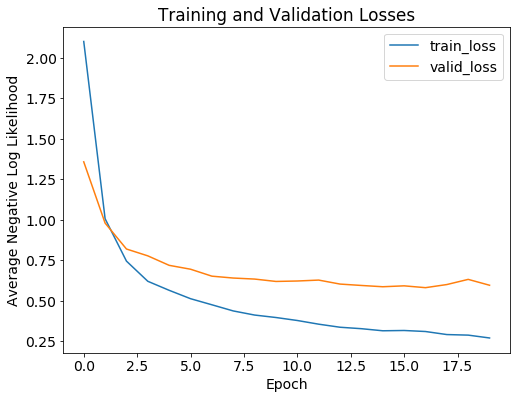

In [26]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

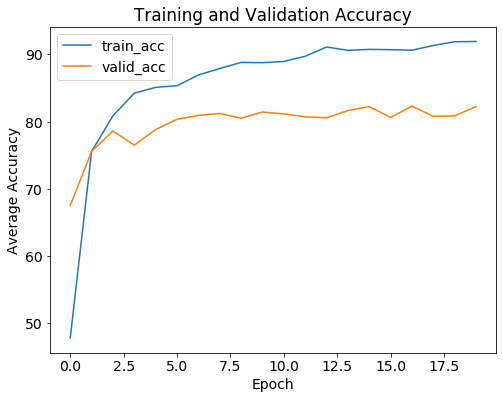

In [27]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

# [ Model Save & Load ]
## 모델 저장

In [34]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # model_name = path.split('-')[0]
    # assert (model_name in ['vgg16', 'resnet50']), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_choice == 'vgg16':
        # Check to see if model was parallelized
        checkpoint['classifier'] = model.classifier
        checkpoint['state_dict'] = model.state_dict()

    elif model_choice == 'resnet50':
        checkpoint['fc'] = model.fc
        checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [35]:
save_checkpoint(model, path=checkpoint_path)

## 모델 불러오기

Now we need to write the function to load in the checkpoint. This just takes in a `path` and returns a model from a saved checkpoint.

In [40]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    # model_name = path.split('-')[0]
    # assert (model_name in ['vgg16', 'resnet50'
    #                        ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_choice == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_choice == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [42]:
model, optimizer = load_checkpoint(path=checkpoint_path)

summary(model, input_size=(3, 224, 224), batch_size=batch_size)

23,569,502 total parameters.
61,470 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
              ReLU-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]           4,096
       BatchNorm2d-6          [128, 64, 56, 56]             128
              ReLU-7          [128, 64, 56, 56]               0
            Conv2d-8          [128, 64, 56, 56]          36,864
       BatchNorm2d-9          [128, 64, 56, 56]             128
             ReLU-10          [128, 64, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]          16,384
      BatchNorm2d-12         [128, 256, 56, 56]             512
           Conv2d-13         [128, 256, 

# [ 추론 ]

In [43]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [44]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [45]:
np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


# _ = imshow_tensor(process_image(random_test_image()))

In [46]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [47]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

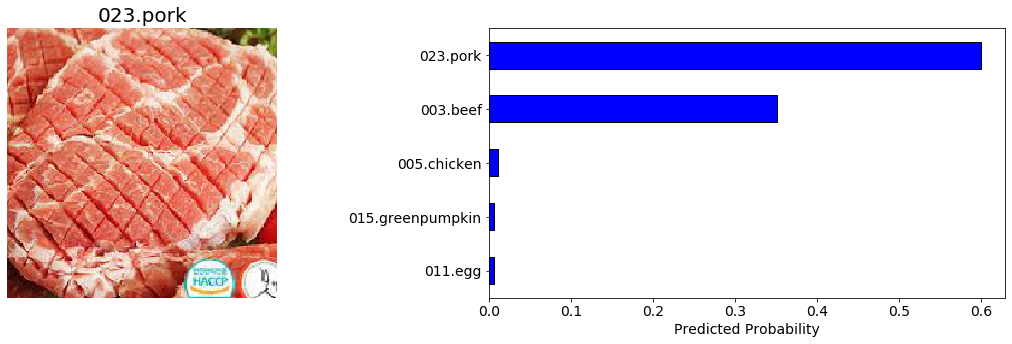

In [48]:
display_prediction(random_test_image(), model, topk=5)

In [49]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [50]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model(features.to('cuda')), targets, topk=(1, 5))
else:
    accuracy(model(features), targets, topk=(1, 5))

[81.25, 98.4375]

In [51]:
def evaluate(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [56]:
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results = evaluate(model, dataloaders['test'], criterion)
results.head()
results.tail()

results.sort_values('top1', ascending=False, inplace=True)
results.tail()


,class,top1,top5,loss
0,001.anchovy,93.548387,100.0,0.261663
1,002.apple,100.000000,100.0,0.015641
2,003.beef,95.454545,100.0,0.253068
3,004.carrot,100.000000,100.0,0.116848
4,005.chicken,62.500000,100.0,0.992459


,class,top1,top5,loss
25,026.shiitake,73.333333,93.333333,0.884230
26,027.shrimp,76.470588,94.117647,1.056616
27,028.smallgreenonion,74.193548,96.774194,1.024388
28,029.spinach,70.588235,100.000000,0.744932
29,030.squid,66.666667,83.333333,1.476099


,class,top1,top5,loss
11,012.eggplant,66.666667,100.000000,0.575851
6,007.chives,66.666667,100.000000,0.526470
29,030.squid,66.666667,83.333333,1.476099
4,005.chicken,62.500000,100.000000,0.992459
8,009.cucumber,50.000000,90.909091,1.714872


Text(0.5, 11.11999999999999, 'images')

Text(6.8700000000000045, 0.5, 'Accuracy (%)')

Text(0.5, 1, 'Top 1 Accuracy vs Number of Training Images')

(-5, 105)

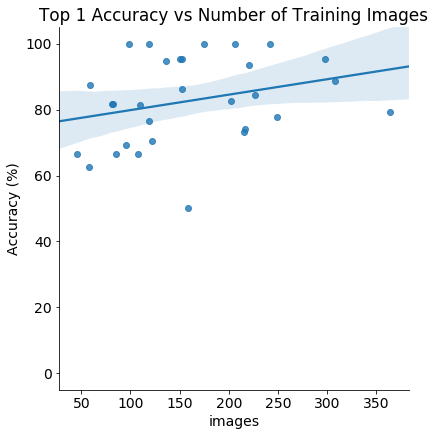

In [53]:
results = results.merge(cat_df, left_on='class', right_on='category').\
    drop(columns=['category'])

# Plot using seaborn
sns.lmplot(
    y='top1', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 1 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)

Text(0.5, 11.11999999999999, 'images')

Text(-6.6299999999999955, 0.5, 'Accuracy (%)')

Text(0.5, 1, 'Top 5 Accuracy vs Number of Training Images')

(-5, 105)

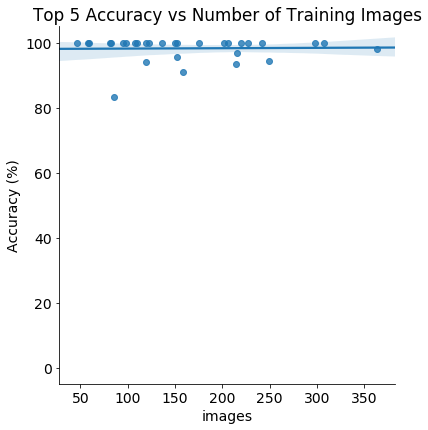

In [55]:
sns.lmplot(
    y='top5', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 5 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)

In [54]:
# Weighted column of test images
results['weighted'] = results['n_test'] / results['n_test'].sum()

# Create weighted accuracies
for i in (1, 5):
    results[f'weighted_top{i}'] = results['weighted'] * results[f'top{i}']

# Find final accuracy accounting for frequencies
top1_weighted = results['weighted_top1'].sum()
top5_weighted = results['weighted_top5'].sum()
loss_weighted = (results['weighted'] * results['loss']).sum()

print(f'Final test cross entropy per image = {loss_weighted:.4f}.')
print(f'Final test top 1 weighted accuracy = {top1_weighted:.2f}%')
print(f'Final test top 5 weighted accuracy = {top5_weighted:.2f}%')

Final test cross entropy per image = 0.5064.
Final test top 1 weighted accuracy = 84.57%
Final test top 5 weighted accuracy = 98.25%
